In [108]:
import numpy as np
import pickle
import torch
import torch.nn as nn
import torch.optim as optim
from matplotlib import pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable
%matplotlib inline

# Import custom modules
from lib.FramesDataset import FramesDataset
from lib import network

# Global variables
WARMUP = 4
T_STEPS = 45
FRAME_SIZE = 20
HIDDEN_UNITS = 800

PATHS = [
    # 130k 20x20 dataset
    './models/model-20framesize-2000epochs-800units-0.00030000000000000003lr-0.25gradclip-1e-06L1-20210214-003950'
]
PATH = PATHS[0]

# Set device to use on network
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print("Using", DEVICE)

# Load previously trained model (2000 epochs)
model = network.RecurrentTemporalPrediction.load(
    hidden_units = HIDDEN_UNITS,
    frame_size = FRAME_SIZE,
    warmup = WARMUP,
    path = PATH + '.pt'
)

# Load dataset
train_dataset = FramesDataset('./datasets/processed_dataset.npy', 'train', WARMUP)
train_data_loader = torch.utils.data.DataLoader(train_dataset, batch_size=128)
print("Training dataset length:", len(train_dataset))

Using cpu
Training dataset length: 14


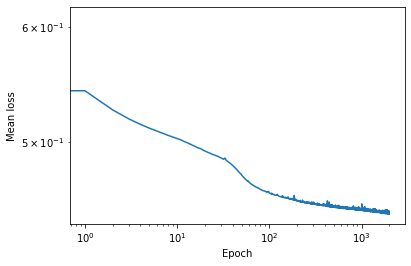

In [91]:
# Plot loss history
with open(PATH + '.pickle', 'rb') as p:
    loss_history = pickle.load(p)
    
plt.loglog(loss_history);
plt.xlabel('Epoch')
plt.ylabel('Mean loss')
plt.show() 

In [71]:
# Produce spike-triggered average
n_rand_stimuli = 15000

stimuli = {}
for i in range(HIDDEN_UNITS):
    stimuli[i] = []

for i in range(n_rand_stimuli):
    if i % 1000 == 0:
        print('Trial %i' % i)
    
    noise_shape = (1, WARMUP+T_STEPS, FRAME_SIZE**2)
    noise = np.random.normal(loc=0, scale=1, size=noise_shape)
    noise = torch.Tensor(noise).to(DEVICE)
    
    _, hidden_state = model(noise)

    units = hidden_state[0, 0, :] # Discard first batch dimension
    for i, unit in enumerate(units):
        if unit > 0:
            stimuli[i].append(noise[0, -1, :].cpu().detach().numpy())

averaged_stimuli = []
for i in range(HIDDEN_UNITS):
    stimuli_len = len(stimuli[i])
    if stimuli_len:
        stimulus = np.stack(stimuli[i])
        stimulus = np.mean(stimulus, 0)
        averaged_stimuli.append(stimulus)
averaged_stimuli = np.array(averaged_stimuli)
        
print('Finished averaging stimuli')

Trial 0
Trial 1000
Trial 2000
Trial 3000
Trial 4000
Trial 5000
Trial 6000
Trial 7000
Trial 8000
Trial 9000
Trial 10000
Trial 11000
Trial 12000
Trial 13000
Trial 14000
Finished averaging stimuli


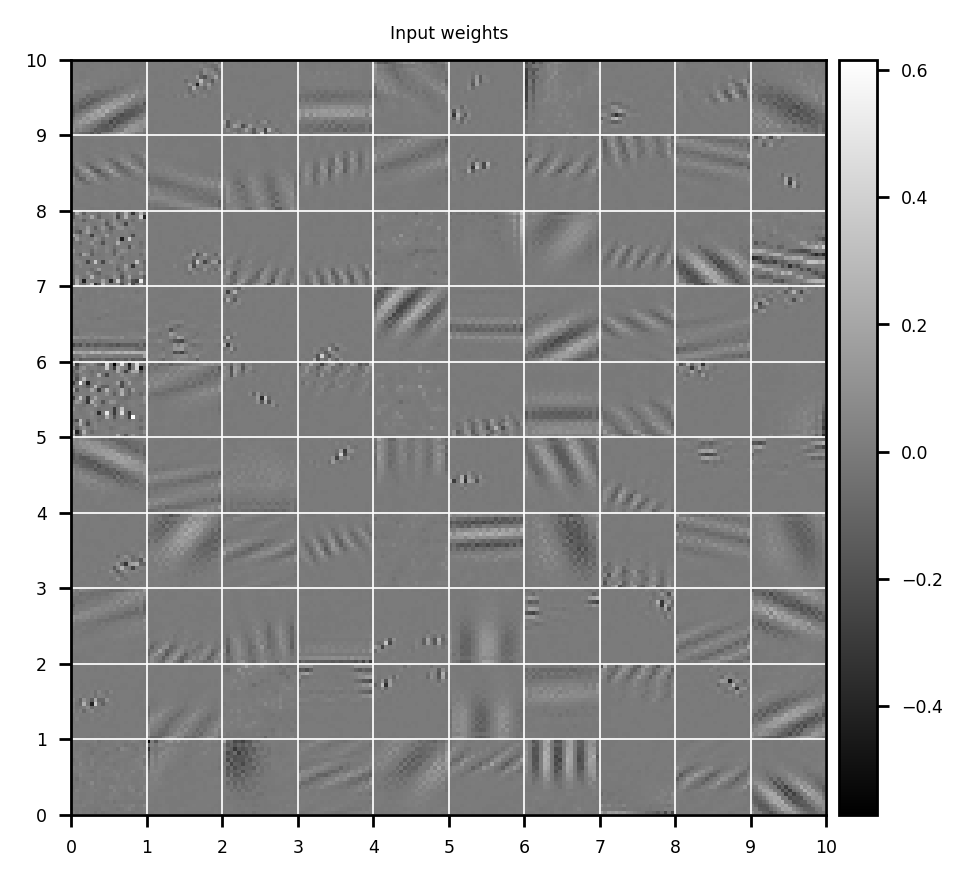

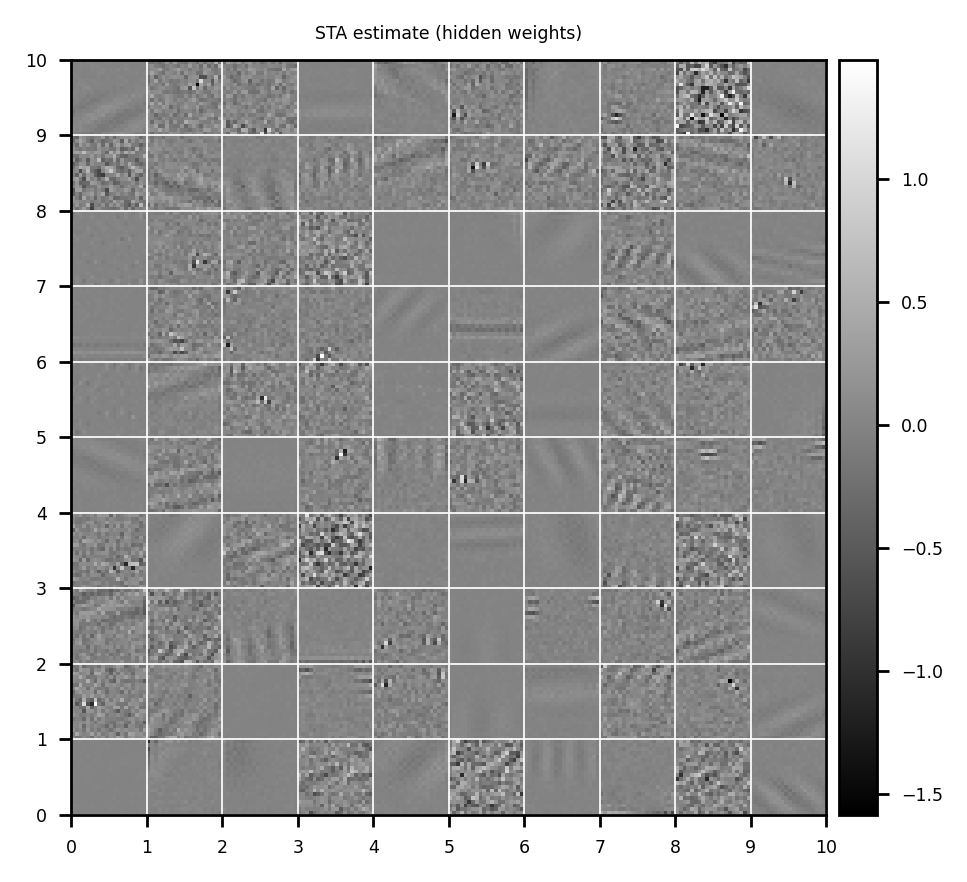

In [109]:
# Plot spike triggered averages and input weights

def plot_weights (weights_array, rows, columns, offset = 0, title = ""):
    font_size = 5
    weights = weights_array[offset:offset+rows*columns, :]
    im = np.zeros((rows*FRAME_SIZE, columns*FRAME_SIZE))
    
    for row in range(rows):
        for column in range(columns):
            idx = row*columns + column
            hidden_unit_weights = weights[idx]
            hidden_unit_weights = np.reshape(hidden_unit_weights, (FRAME_SIZE, FRAME_SIZE))
            im[row*FRAME_SIZE:(row+1)*FRAME_SIZE, column*FRAME_SIZE:(column+1)*FRAME_SIZE] = hidden_unit_weights

    fig, ax = plt.subplots(dpi=250)
    im_plt = plt.imshow(im, extent=[0, columns, 0, rows], cmap='gray')
    
    divider = make_axes_locatable(ax)
    cax = divider.append_axes('right', size='5%', pad=0.05)
    cb_plt = plt.colorbar(im_plt, cax=cax)
    cb_plt.ax.tick_params(labelsize=font_size)

    ax.set_xticks(np.arange(0, columns+1))
    ax.set_xticklabels(np.arange(0, columns+1), size=font_size)
    ax.set_yticks(np.arange(0, rows+1))
    ax.set_yticklabels(np.arange(0, rows+1), size=font_size)
    ax.grid(which='major', color='w', linestyle='-', linewidth=0.5)
    ax.set_title(title, size=font_size)

rows, columns, offset = (10, 10, 0)
plot_weights(model.rnn.weight_ih_l0.cpu().detach().numpy(), rows, columns, offset, "Input weights")
plot_weights(averaged_stimuli, rows, columns, offset, "STA estimate (hidden weights)")

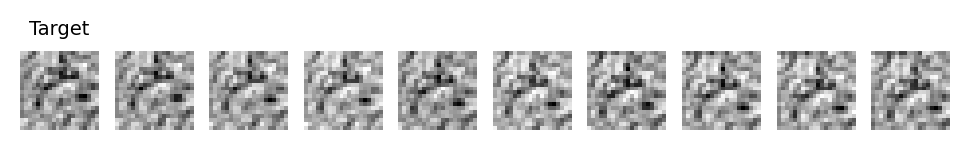

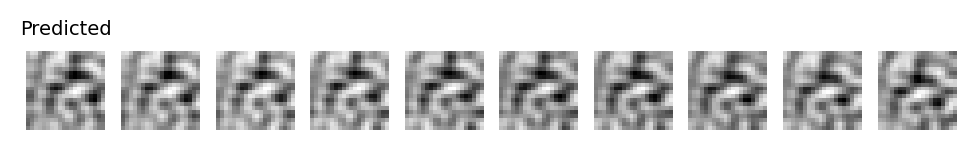

In [19]:
# Visualise network predictions

x, y = train_dataset[0]
x = x.to(DEVICE)
y = y.to(DEVICE)
pred, _ = model(torch.unsqueeze(x, 0))
pred = torch.squeeze(pred, 0)

steps = 10

fig, axes = plt.subplots(1, steps, dpi=200)
for i in range(steps):
    im_y = y[WARMUP+i].view(20, 20).detach().cpu().numpy()
    axes[i].imshow(im_y, cmap='gray')
    axes[i].axis('off')
axes[0].set_title('Target', size=7)
plt.show()

fig, axes = plt.subplots(1, steps, dpi=200)
for i in range(steps):
    im_pred = pred[i].view(20, 20).detach().cpu().numpy()
    axes[i].imshow(im_pred, cmap='gray')
    axes[i].axis('off')
axes[0].set_title('Predicted', size=7)
plt.show()